In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd

In [2]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')

skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

sales = sales.join(skus, on='SKU')

#### Clean dataset

In [3]:
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.loc[sales['date'] > '2020-04-01']
sales['sales'] = sales['sales'].fillna(1)

In [4]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

In [5]:
sales_time_series = sales.groupby('date')['sales'].sum().reindex(timeframe_of_interest, fill_value=0).reset_index()
sales_time_series.rename(columns={'index': 'ds', 'sales': 'y'}, inplace=True)

training_set = sales_time_series.iloc[:-120]
validation_set = sales_time_series.iloc[-120:]

<AxesSubplot:xlabel='ds'>

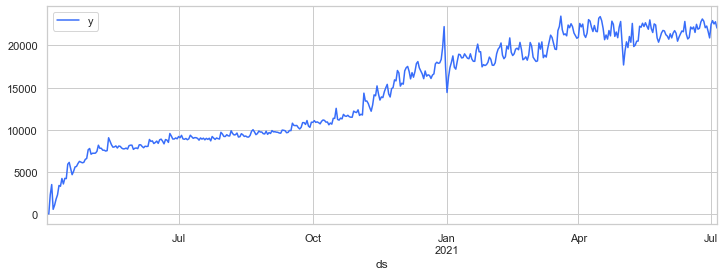

In [6]:
sales_time_series.plot(x='ds', y='y', figsize=(12, 4))

#### NeuralProphet

In [7]:
import neuralprophet

In [8]:
m = neuralprophet.NeuralProphet()
m.add_country_holidays(country_name='US', lower_window=-4, upper_window=2)

In [9]:
m.fit(training_set)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a

  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.82E-01, min: 1.11E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.52E-01, min: 1.58E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.41E-01
Epoch[287/287]: 100%|██████████| 287/287 [00:10<00:00, 26.67it/s, SmoothL1Loss=0.000271, MAE=311, RMSE=443, RegLoss=0]       


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.459166,16188.182881,19968.402355,0.0
1,0.428010,15440.870473,19234.956158,0.0
2,0.396600,14676.073024,18249.843382,0.0
3,0.361339,13826.181359,17356.822059,0.0
4,0.323792,12884.619704,16214.170094,0.0
...,...,...,...,...
282,0.000271,311.264163,440.542891,0.0
283,0.000271,310.917230,440.777554,0.0
284,0.000271,310.908177,441.887252,0.0
285,0.000271,310.759185,437.935759,0.0


In [10]:
training_set_forecast = m.predict(training_set)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  additive_events[key] = offset_feature

WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: Perf

In [11]:
future = m.make_future_dataframe(training_set, periods=14, n_historic_predictions=200)
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.706% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.533% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.533% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophe

<AxesSubplot:xlabel='ds'>

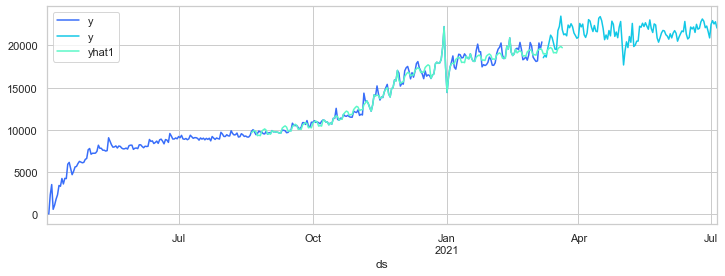

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))

training_set.plot(x='ds', y='y', ax=ax)
validation_set.plot(x='ds', y='y', ax=ax)
forecast.plot(x='ds', y='yhat1', ax=ax)